In [1]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

### callback functions

In [2]:
optimizer = SGD(learning_rate=1e-2, momentum=9e-1)
weight_decay = 5e-4
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1e-1, patience=20)
model_checkpoint = ModelCheckpoint(filepath='vgg16_checkpoint.hdf5', save_best_only=True)
classes = 6
epoch = 75

In [3]:
def vgg_nett16(input_shape=(224, 224, 3), classes=None):
    # input layer
    input_layer = Input(shape=input_shape, name='input_')

    # first conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(input_layer)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # second conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # third conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fourth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fifth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same',
               activation=relu)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # classifier
    x = Flatten()(x)
    x = Dense(units=512, activation=relu)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=512, activation=relu)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes, activation=softmax)(x)

    model = Model(input_layer, x)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
    model.summary()

    return model


### utility functions

In [14]:
def save_train_history(history_dict, file_path):
    temp = pd.DataFrame(history_dict.history)

    try:
        temp.to_pickle(file_path)

    except FileNotFoundError:
        print('file not found.')


def create_metric_graph(history_dict, metric='accuracy', validation=True, file_path=None):
    epochs = list(range(len(history_dict.history[metric])))

    plt.figure(figsize=[12, 6], dpi=300)
    sns.lineplot(x=epochs,
                 y=history_dict.history[metric],
                 marker='o',
                 label='training')

    if validation:
        sns.lineplot(x=epochs,
                     y=history_dict.history[f'val_{metric}'],
                     marker='o',
                     linestyle='--',
                     label='validation')

    plt.xlabel('epoch')
    plt.ylabel(f'{metric}')

    if file_path is not None:
        plt.savefig(file_path)

    plt.show()


def create_loss_graph(history_dict, validation=True, file_path=None):
    epochs = list(range(len(history_dict.history['loss'])))

    plt.figure(figsize=[12, 6], dpi=300)
    sns.lineplot(x=epochs,
                 y=history_dict.history['loss'],
                 marker='o',
                 label='training')

    if validation:
        sns.lineplot(x=epochs,
                     y=history_dict.history['val_loss'],
                     marker='o',
                     linestyle='--',
                     label='validation')

    plt.xlabel('epoch')
    plt.ylabel('loss')

    if file_path is not None:
        plt.savefig(file_path)

    plt.show()


def create_learning_rate(history_dict, file_path=None):
    epochs = list(range(len(history_dict.history['lr'])))
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)

    sns.lineplot(x=epochs,
                 y=history_dict.history['lr'],
                 ax=axes[0])

    sns.scatterplot(x=history_dict.history['loss'],
                    y=history_dict.history['lr'],
                    label='training loss',
                    ax=axes[1])

    sns.scatterplot(x=history_dict.history['val_loss'],
                    y=history_dict.history['lr'],
                    label='validation loss',
                    ax=axes[1])

    axes[0].set_title('learning rate change through training')
    axes[1].set_title('learning rate changes with loss')

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('learning rate')
    axes[1].set_xlabel('loss')
    axes[1].set_ylabel('learning rate')

    if file_path is not None:
        plt.savefig(file_path)

    plt.show()


In [6]:
model = vgg_nett16(input_shape=(150, 150, 3), classes=classes)

2022-02-17 11:03:42.999124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 11:03:43.111650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 11:03:43.112841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ (InputLayer)          [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0     

2022-02-17 11:03:43.115494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 11:03:43.116572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 11:03:43.117814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 11:03:43.118967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
plot_model(model,
           to_file='../../images/computer vision/vgg16.png',
           show_dtype=True,
           show_shapes=True,
           show_layer_names=True)

In [24]:
generator = ImageDataGenerator(rescale=1 / 255.,
                               validation_split=0.3)
train_gen = generator.flow_from_directory(directory='../input/intel-image-classification/seg_train/seg_train',
                                          target_size=(150,150),
                                          subset='training')
valid_gen = generator.flow_from_directory(directory='../input/intel-image-classification/seg_train/seg_train',
                                          target_size=(150,150),
                                          subset='validation')
test_gen = generator.flow_from_directory('../input/intel-image-classification/seg_test/seg_test',
                                         target_size=(150,150))

Found 9826 images belonging to 6 classes.
Found 4208 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
history = model.fit(x=train_gen,
                    epochs=epoch,
                    validation_data=valid_gen,
                    callbacks=[reduce_lr, model_checkpoint])

Epoch 1/75
308/308 [==============================] - 98s 310ms/step - loss: 3.5862 - accuracy: 0.2508 - val_loss: 3.1221 - val_accuracy: 0.4855
Epoch 2/75
308/308 [==============================] - 37s 121ms/step - loss: 3.0216 - accuracy: 0.4967 - val_loss: 2.7454 - val_accuracy: 0.5737
Epoch 3/75
308/308 [==============================] - 37s 120ms/step - loss: 2.6976 - accuracy: 0.5822 - val_loss: 2.5000 - val_accuracy: 0.6502
Epoch 4/75
308/308 [==============================] - 37s 121ms/step - loss: 2.5056 - accuracy: 0.6222 - val_loss: 2.3910 - val_accuracy: 0.6576
Epoch 5/75
308/308 [==============================] - 38s 122ms/step - loss: 2.3730 - accuracy: 0.6478 - val_loss: 2.2835 - val_accuracy: 0.6568
Epoch 6/75
308/308 [==============================] - 37s 121ms/step - loss: 2.2467 - accuracy: 0.6677 - val_loss: 2.2016 - val_accuracy: 0.6723
Epoch 7/75
308/308 [==============================] - 41s 133ms/step - loss: 2.1093 - accuracy: 0.6929 - val_loss: 2.0035 - val_ac

In [12]:
save_train_history(history, 'vgg16.pkl')

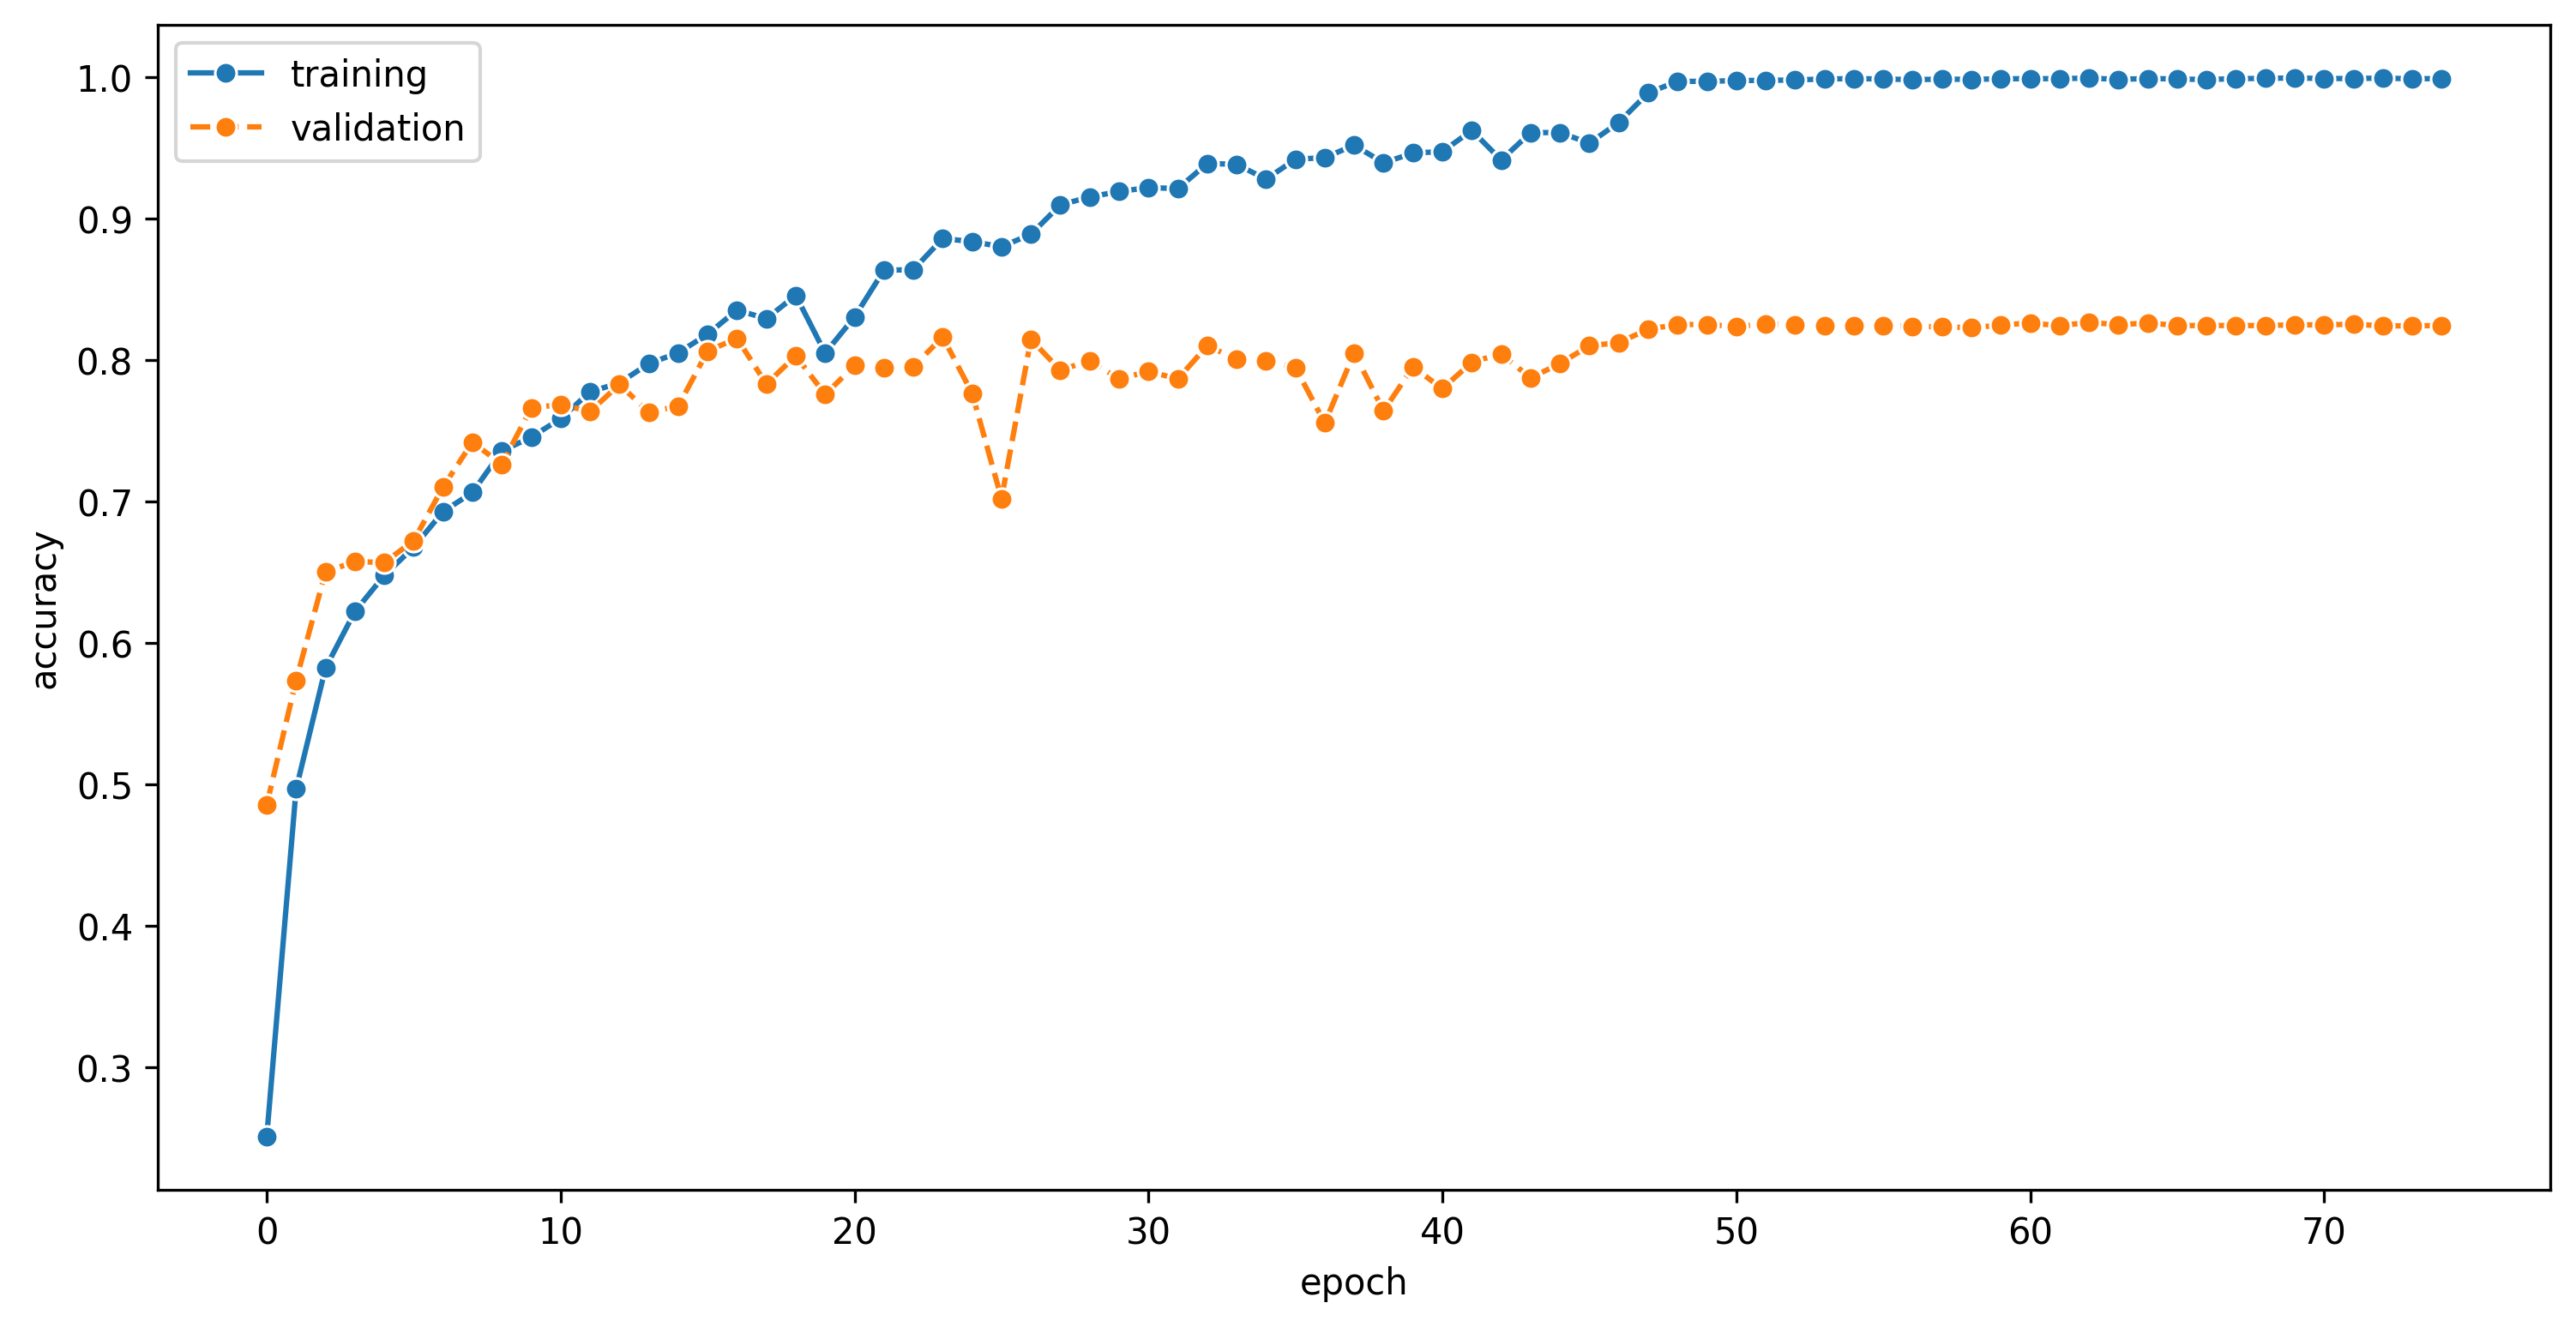

In [17]:
create_metric_graph(history, file_path='accuracy_vgg16.png')

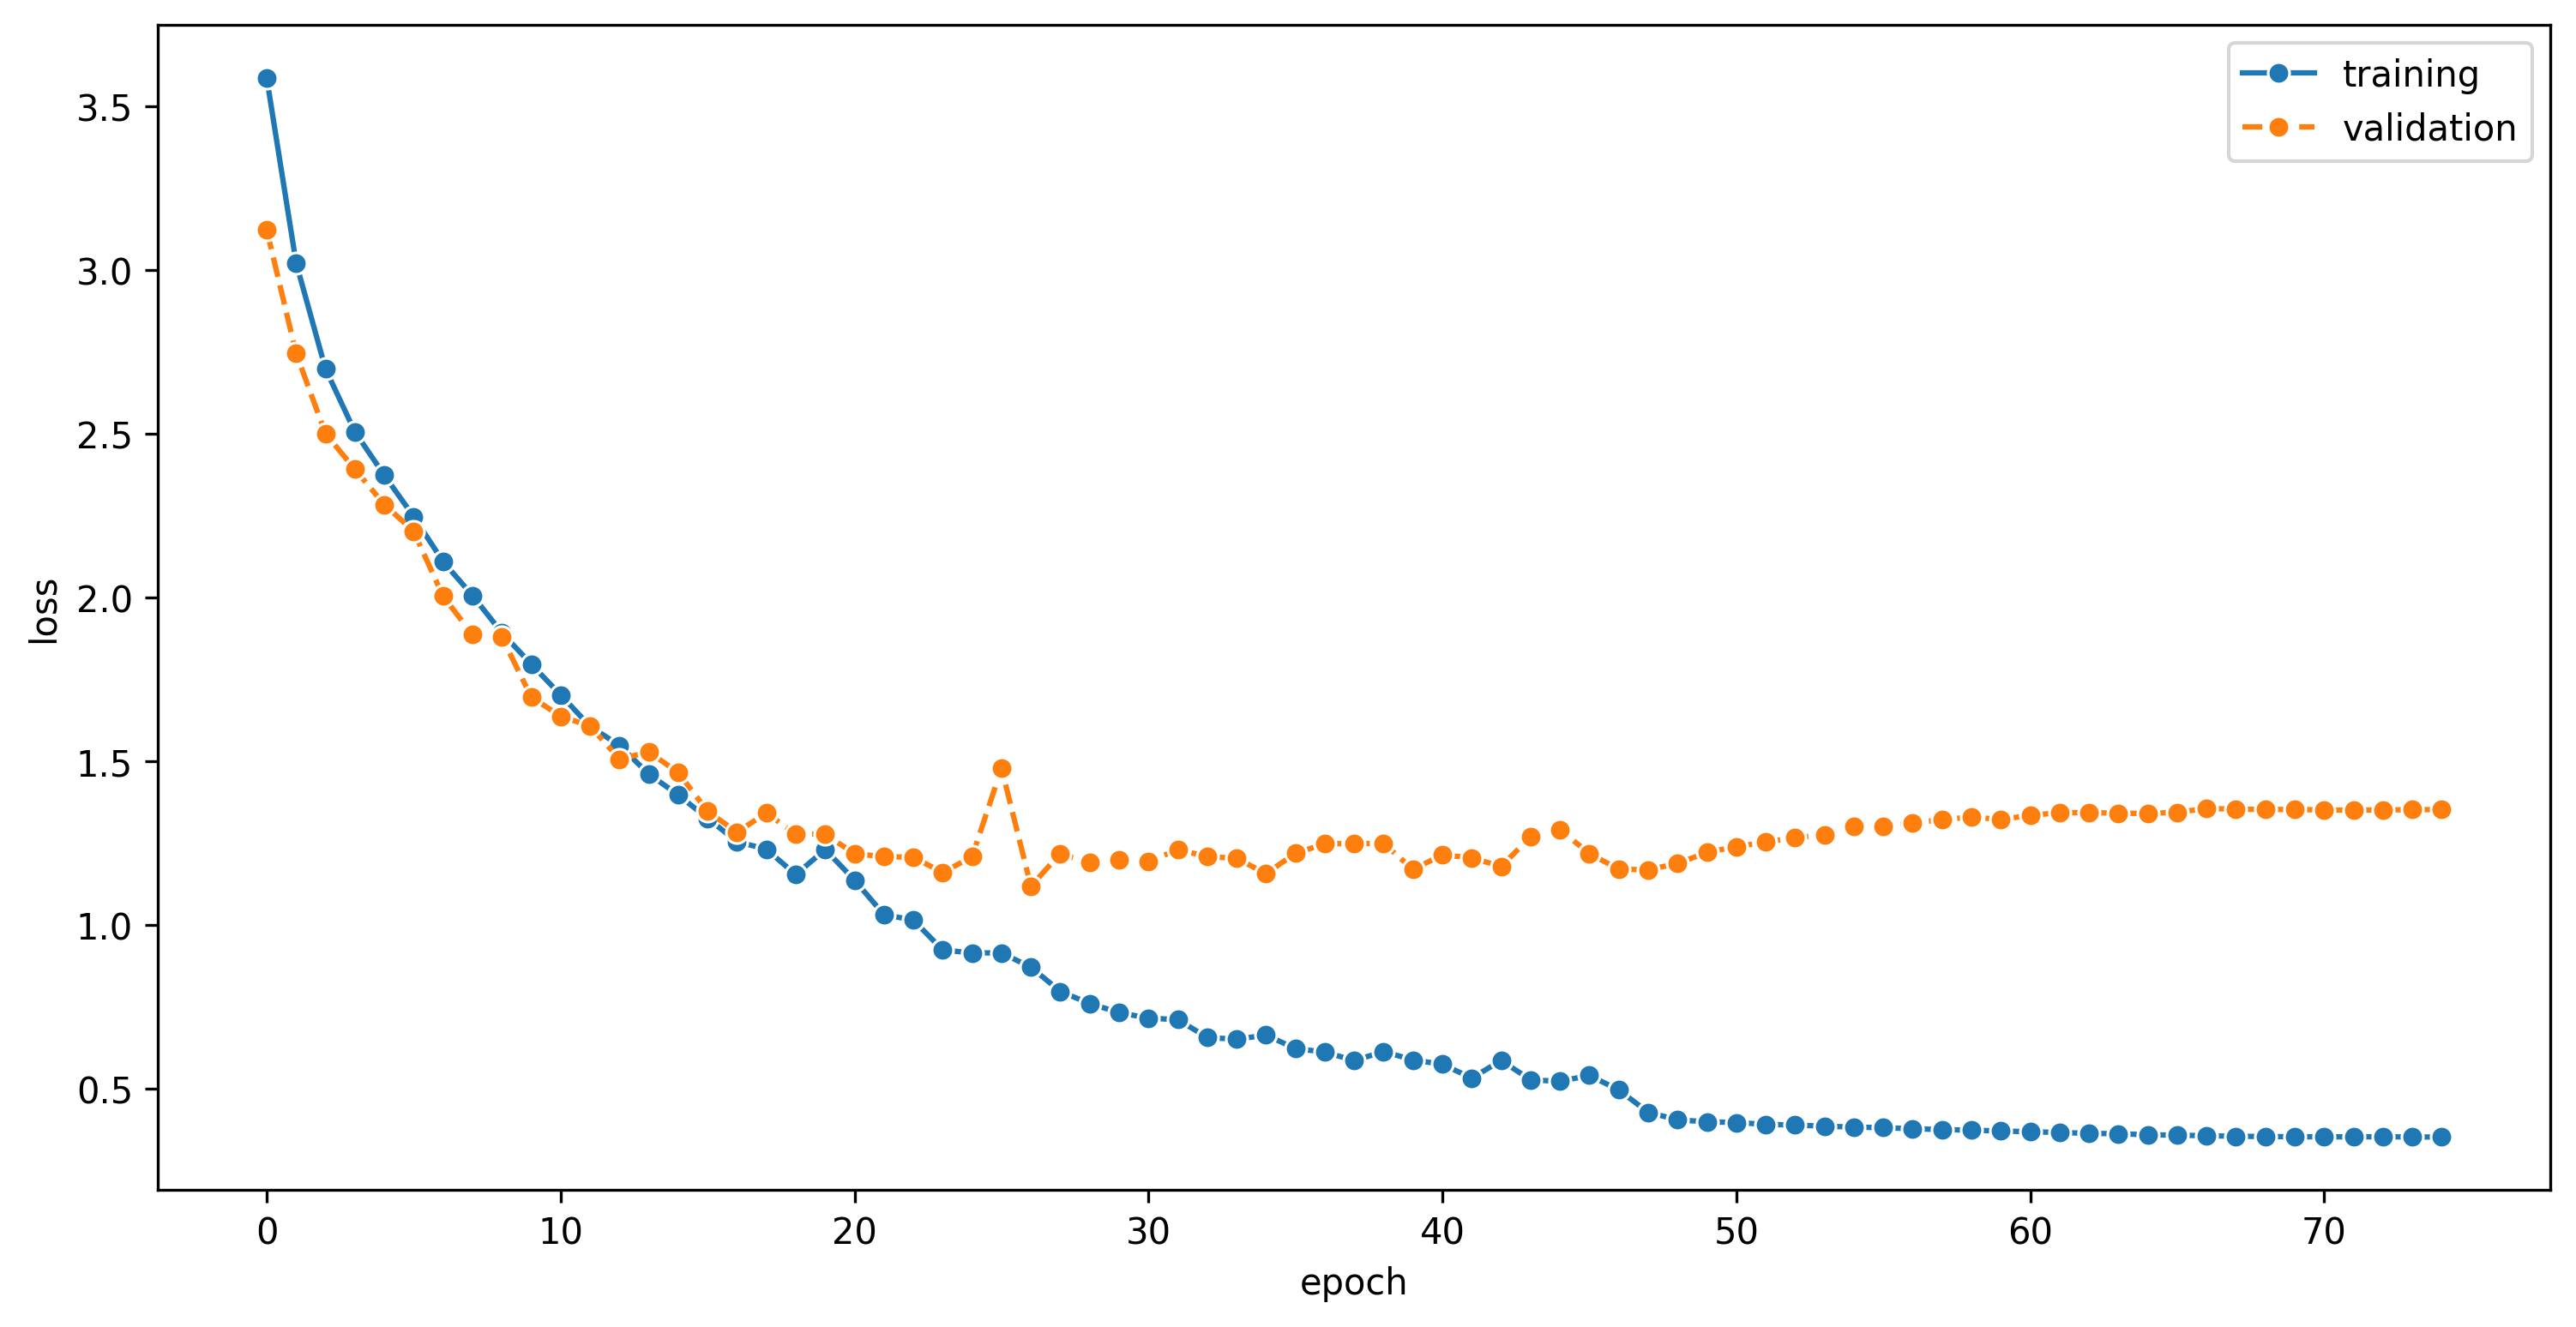

In [19]:
create_loss_graph(history, file_path='loss_vgg16.png')

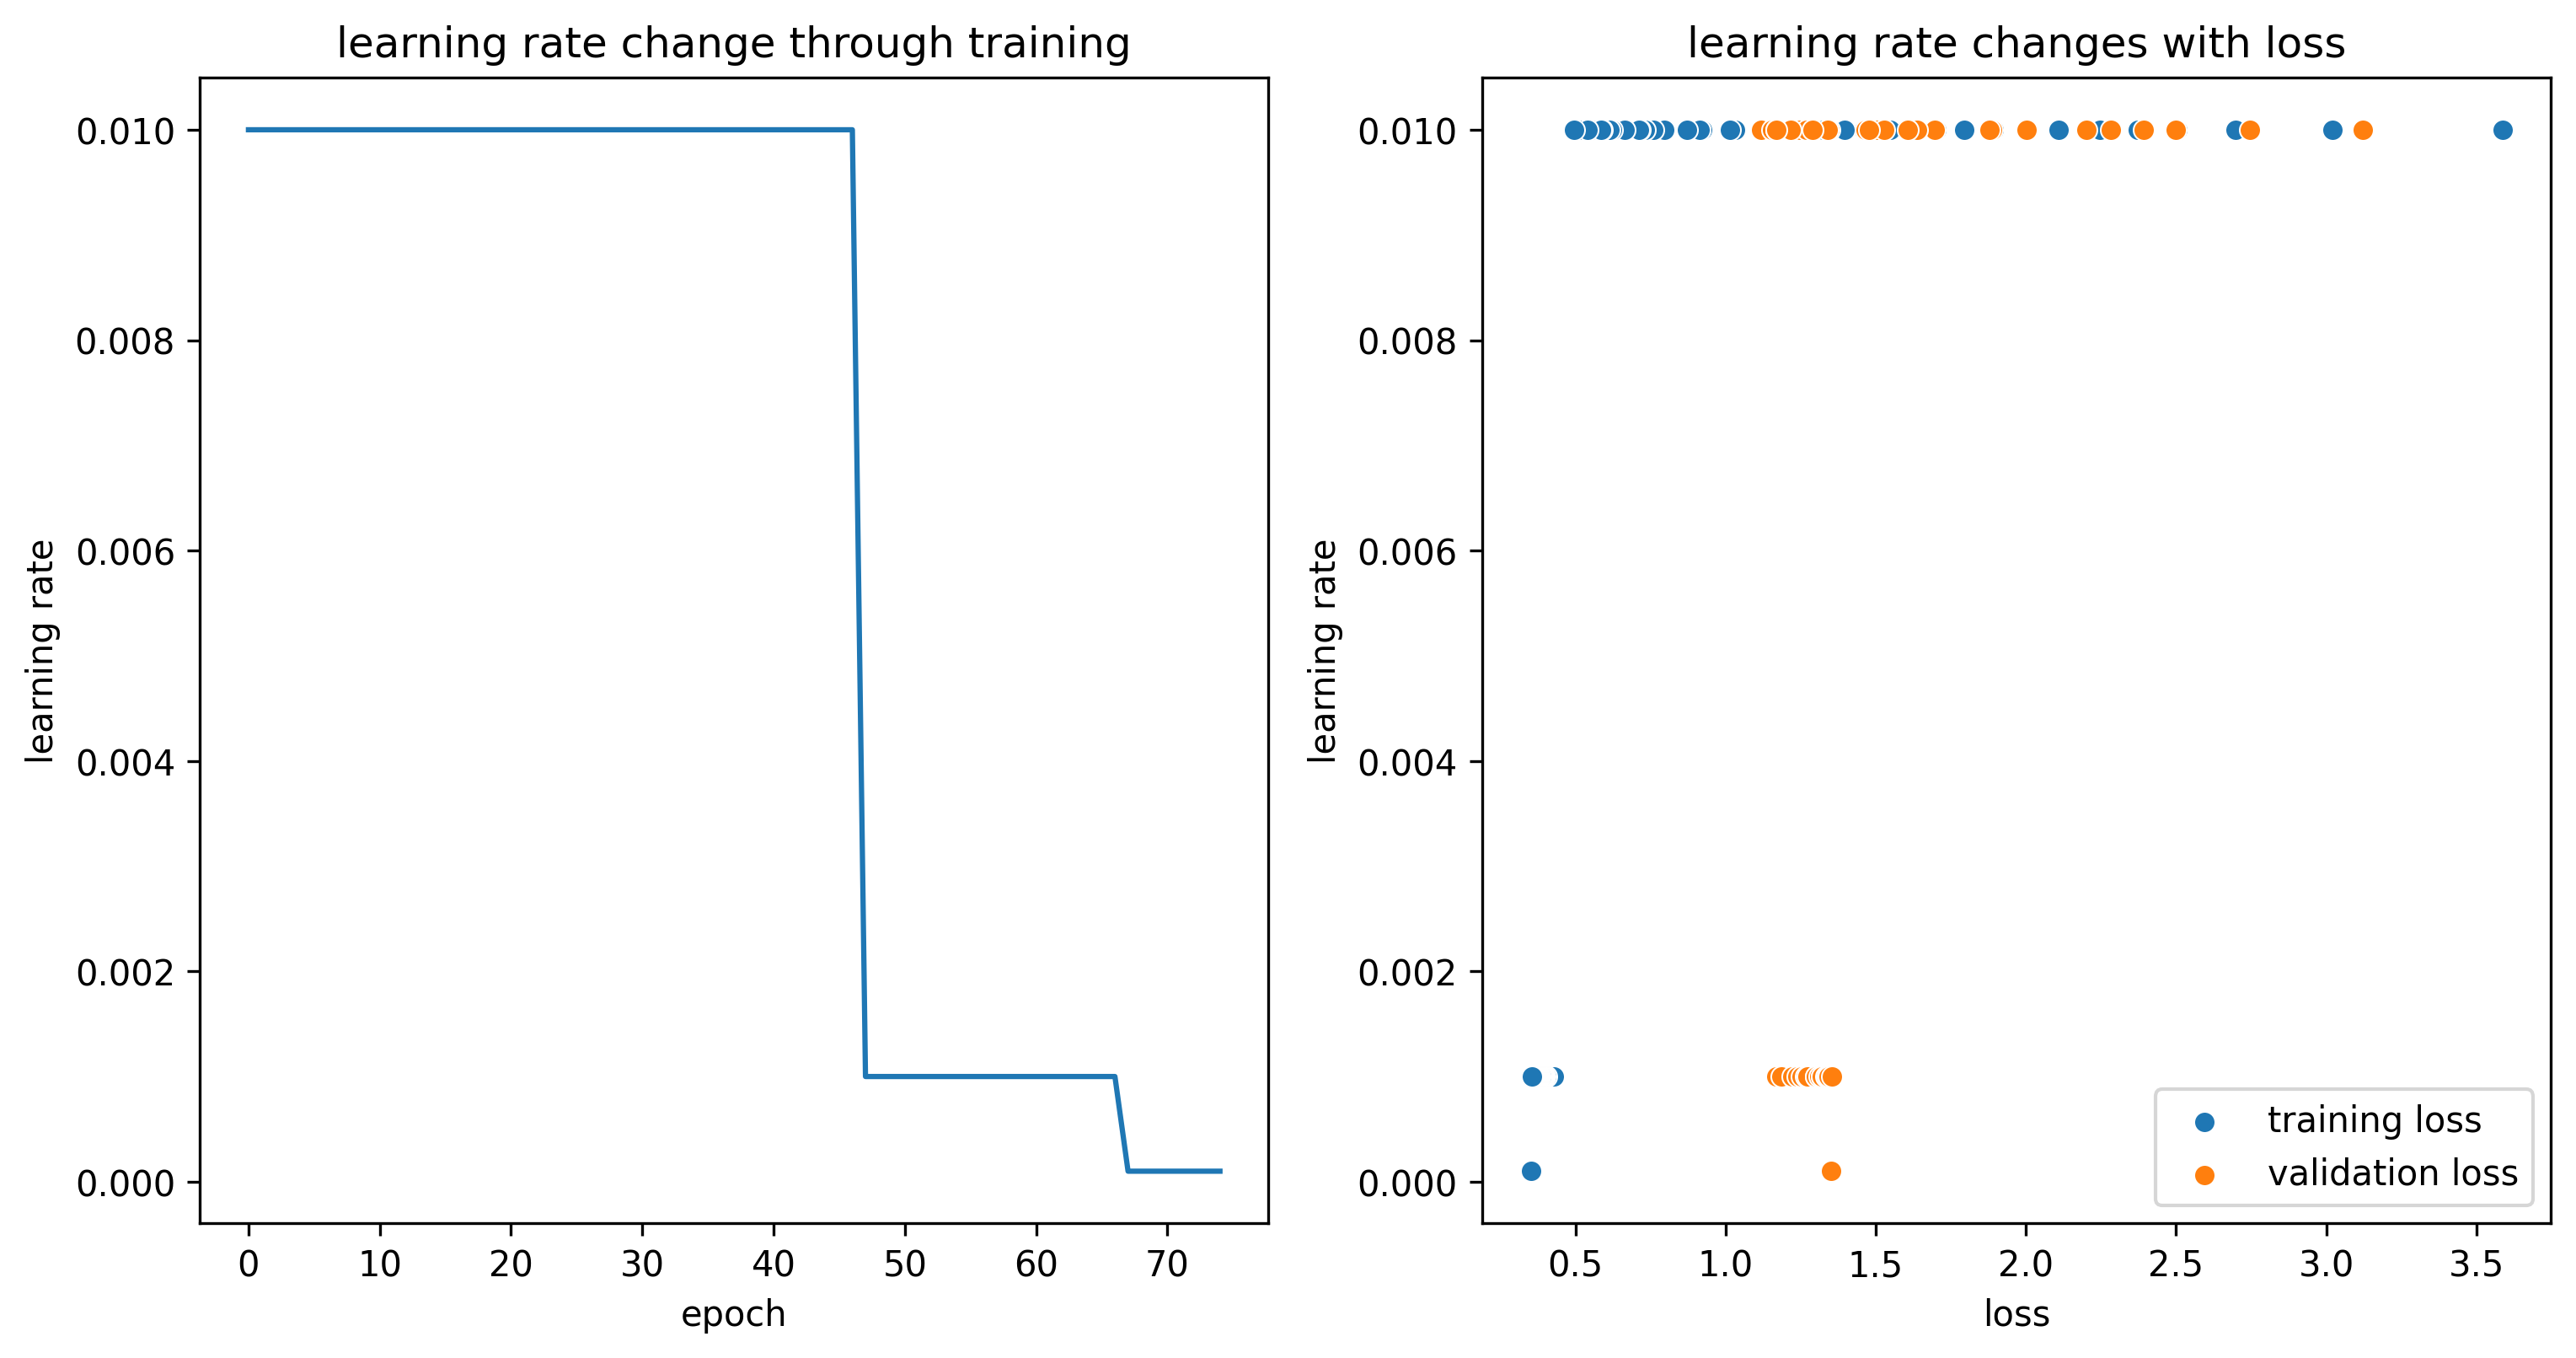

In [21]:
create_learning_rate(history, file_path='learning_rate_vgg16.png')

In [25]:
model.evaluate(test_gen)

94/94 [==============================] - 36s 387ms/step - loss: 1.4058 - accuracy: 0.8243


[1.4058364629745483, 0.8243333101272583]